In [1]:
import math
import time

import h5py
import matplotlib.pyplot as plt
import mlflow
import numpy as np
from numpy.random import choice
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
from torch.optim import SGD, Optimizer, Adam, RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from tqdm.auto import tqdm as tq

from craterdetection.detection.model import DeepMoon
from craterdetection.detection.training import CraterDataset, RAdam, dice_coefficient, SoftDiceLoss, f_score, BCEDiceLoss, TverskyLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("crater-detection")

In [3]:
dataset_path = "../data/dataset4.h5"
train_dataset = CraterDataset(dataset_path, "training", device)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0)

validation_dataset = CraterDataset(dataset_path, "validation", device)
validation_loader = DataLoader(train_dataset, batch_size=20, num_workers=0)

test_dataset = CraterDataset(dataset_path, "test", device)
test_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=0)

In [4]:
model = DeepMoon(sigmoid=False, drop=0.15)
model.load_state_dict(torch.load("../blobs/DeepMoon.pth"))

# optimizer = RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-8, momentum=0.0)
optimizer = SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=1e0)
# optimizer = Adam(model.parameters(), lr=1e-3)
# loss_function = SoftDiceLoss()
# loss_function = nn.BCEWithLogitsLoss()
loss_function = BCEDiceLoss(lambda_dice=0.5)
# loss_function = TverskyLoss(alpha=0.3, beta=0.7)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True, cooldown=2)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

model.to(device)
loss_function.to(device)

BCEDiceLoss(
  (bce): BCEWithLogitsLoss()
  (dice): SoftDiceLoss()
)

In [5]:
num_epochs = 2

with mlflow.start_run(run_name="Testing"):

    mlflow.log_param('optimizer', type(optimizer).__name__)
    mlflow.log_param('loss_function', type(loss_function).__name__)

    mlflow.log_param('drop', 0.15)
    mlflow.log_param('momentum', 0.0)
    mlflow.log_param('weight_decay', 1e-2)

    train_loss_list = []
    valid_loss_list = []
    dice_score_list = []

    for e in range(1, num_epochs+1):
        print(f'\n-----Epoch {e} started-----\n')

        since = time.time()

        train_loss, valid_loss, dice_score = 0, 0, 0

        model.train()

        bar = tq(train_loader, desc=f"Training [{e}]", postfix={"train_loss": 0.0})
        for batch, (images, masks) in enumerate(bar, 1):
            # images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            with autocast():
                pred = model(images)
                loss = loss_function(pred, masks)

            loss.backward()
            train_loss += loss.item() * images.size(0)

            optimizer.step()
            bar.set_postfix(ordered_dict={"train_loss": loss.item()})

        train_loss = train_loss/len(train_loader.dataset)
        train_loss_list.append(train_loss)
        mlflow.log_metric("train_loss", train_loss, step=e)

        model.eval()
        del images, masks
        with torch.no_grad():
            bar = tq(validation_loader, desc=f"Validation [{e}]", postfix={"valid_loss": 0.0, "dice_score": 0.0})
            for images, masks in bar:
                # images, masks = images.to(device), masks.to(device)

                with autocast():
                    logits = model(images)
                    loss = loss_function(logits, masks)

                valid_loss += loss.item()*images.size(0)
                dice_cof = dice_coefficient(nn.Sigmoid()(pred), masks).item()
                dice_score +=  dice_cof * images.size(0)
                bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
        # calculate average losses
        valid_loss = valid_loss/len(validation_loader.dataset)
        valid_loss_list.append(valid_loss)

        dice_score = dice_score/len(validation_loader.dataset)
        dice_score_list.append(dice_score)

        mlflow.log_metric("valid_loss", valid_loss, step=e)
        mlflow.log_metric("dice_score", dice_score, step=e)

        time_elapsed = time.time() - since
        scheduler.step(valid_loss)

        print(
            f"\nSummary:\n",
            f"\tEpoch: {e}/{num_epochs}\n",
            f"\tAverage train loss: {train_loss}\n",
            f"\tAverage validation loss: {valid_loss}\n",
            f"\tAverage Dice score: {dice_score}\n",
            f"\tDuration: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s"
        )
        print(f'-----Epoch {e} finished.-----\n')


-----Epoch 1 started-----


Summary:
 	Epoch: 1/2
 	Average train loss: 5.482600042819977
 	Average validation loss: 4.102293324947357
 	Average Dice score: 0.013931308837607502
 	Duration: 5m 37s
-----Epoch 1 finished.-----


-----Epoch 2 started-----


Summary:
 	Epoch: 2/2
 	Average train loss: 3.539276861667633
 	Average validation loss: 2.9516449897289276
 	Average Dice score: 0.013365406741388142
 	Duration: 5m 28s
-----Epoch 2 finished.-----



Training [1]:   0%|          | 0/500 [00:00<?, ?it/s, train_loss=0]

Validation [1]:   0%|          | 0/500 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Training [2]:   0%|          | 0/500 [00:00<?, ?it/s, train_loss=0]

Validation [2]:   0%|          | 0/500 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

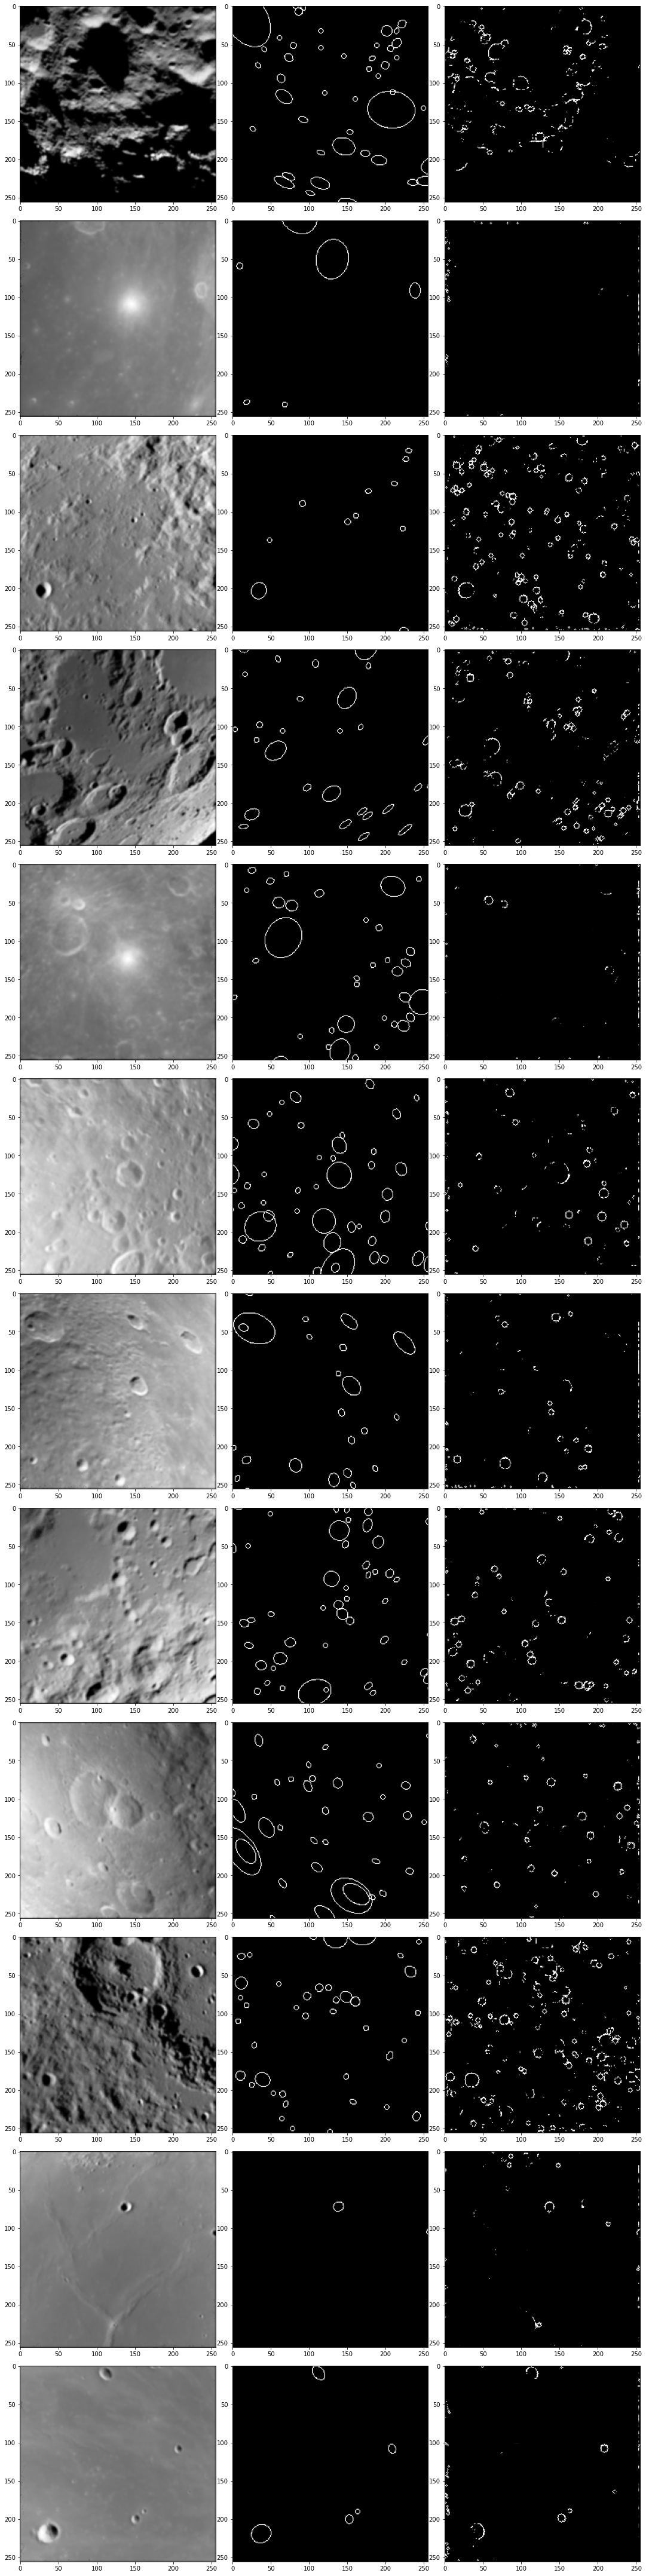

In [6]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)
model.eval()
with torch.no_grad():
    out = nn.Sigmoid()(model(images))
    # out = out > 0.5

fig, axes = plt.subplots(12, 3, figsize=(15, 60))

for i in range(12):
    axes[i, 0].imshow(images[i, 0].cpu().numpy()*255, cmap='Greys_r')
    axes[i, 1].imshow(masks[i, 0].cpu().numpy(), cmap='Greys_r')
    axes[i, 2].imshow(out[i, 0].cpu().numpy(), cmap='Greys_r')
fig.tight_layout()

In [ ]:
model.eval()
test_loss, dice_score, f1, f1_ = 0, 0, 0, 0
with torch.no_grad():
    bar = tq(test_loader, postfix={"test_loss": 0.0, "dice_score": 0.0, "f_score": 0.0})
    for images, masks in bar:
        images, masks = images.to(device), masks.to(device)

        with autocast():
            pred = model(images)
            loss = loss_function(pred, masks)

        test_loss += loss.item()*images.size(0)
        dice_cof = dice_coefficient(nn.Sigmoid()(pred), masks).item()
        dice_score += dice_cof * images.size(0)
        f1 = f_score(pred, images, threshold=0.1).item() * images.size(0)
        f1_ += f1
        bar.set_postfix(ordered_dict={"test_loss":loss.item(), "dice_score":dice_cof, "f_score": f1})

    test_loss /= len(test_loader.dataset)
    dice_score /= len(test_loader.dataset)
    f1_ /= len(test_loader.dataset)
print(f"test_loss: {test_loss} \ndice_score: {dice_score} \nf_score: {f1}")